In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Deep Learning U-Net (dataset: *.jpg obrázky + *.png masky se stejným názvem)
# Instalace potřebných knihoven (Torch + TorchVision)
!pip install torch torchvision -q

# Import knihoven pro práci s daty, tréninkem a vizualizací
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2, numpy as np, matplotlib.pyplot as plt
import glob, os, random
from sklearn.model_selection import train_test_split

In [3]:
# 0) Parametry, úpravy dle experimentu
# Nastavení cesty k datům, velikosti obrázků, počtu epoch, batch size, validačního splitu atd.
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/segment"
IMG_SIZE = 256          # 128/160/256 (vyšší = lepší detail, pomalejší trénink)
N_SUBSET = 800          # kolik párů náhodně vybrat (v sadě je cca 940 párů)
EPOCHS   = 100           # počet epoch tréninku
BATCH    = 32           # velikost batchu
VAL_SPLIT= 0.2
PRED_THR = 0.4          # práh pro binarizaci predikce při vizualizaci (0.3–0.5)

# Nastavení seedů pro reprodukovatelnost
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [4]:
# 1) Jednoduchý U-Net (výstup = logits, BEZ sigmoidu; sigmoid použijeme až při vyhodnocení)
# Architektura pro segmentaci: 3 enkodery, 2 dekodery, skip connections, výstup bez sigmoidu
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True))
        self.enc1 = CBR(1,16); self.enc2 = CBR(16,32); self.enc3 = CBR(32,64)
        self.pool = nn.MaxPool2d(2)
        self.up2  = nn.ConvTranspose2d(64,32,2,stride=2)
        self.up1  = nn.ConvTranspose2d(32,16,2,stride=2)
        self.dec2 = CBR(64,32); self.dec1 = CBR(32,16)
        self.outc = nn.Conv2d(16,1,1)
    def forward(self,x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.up2(e3)
        d2 = self.dec2(torch.cat([d2,e2],1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1,e1],1))
        return self.outc(d1)

In [5]:
# 2) Dataset loader (s lehkou augmentací)
# Načítání obrázků a masek, resize, normalizace, augmentace (flip), převod na tensory

class SimpleSegDataset(Dataset):
    def __init__(self, img_paths, mask_paths, size=128, augment=False):
        self.imgs, self.masks, self.size, self.augment = img_paths, mask_paths, size, augment
    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        img  = cv2.imread(self.imgs[i],  cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.masks[i], cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            raise RuntimeError(f"Nelze načíst: {self.imgs[i]} / {self.masks[i]}")
        img  = cv2.resize(img,  (self.size, self.size), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        # jednoduchá augmentace: náhodné převrácení
        if self.augment and random.random() < 0.5:
            img  = cv2.flip(img, 1); mask = cv2.flip(mask, 1)
        if self.augment and random.random() < 0.2:
            img  = cv2.flip(img, 0); mask = cv2.flip(mask, 0)

        img  = (img/255.0).astype(np.float32)
        mask = (mask>0).astype(np.float32)

        img_t  = torch.from_numpy(img).unsqueeze(0)
        mask_t = torch.from_numpy(mask).unsqueeze(0)
        return img_t, mask_t

In [6]:
# 3) Doplňkové funkce pro evaluaci (IoU)
def iou_score(pred, target):
    """Vypočítá Intersection over Union (IoU) pro jeden obrázek."""
    smooth = 1e-6
    # Převod na binární float pro jistotu, i když by měly být binární
    pred = pred.float()
    target = target.float()

    # Průnik a sjednocení
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    return (intersection + smooth) / (union + smooth)

def evaluate_unet(model, dl, device, thr=0.4):
    """Vyhodnotí model na celém DataLoaderu a spočítá průměrné IoU a std."""
    model.eval()
    iou_list = []

    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(device), y.to(device)

            # Predikce (logits)
            logits = model(x)

            # Převod logitů na pravděpodobnost a binarizace
            prob = torch.sigmoid(logits)
            pred_bin = (prob > thr).float()

            # Výpočet IoU pro každý vzorek v batchi
            # Tvary jsou obvykle [BATCH, 1, H, W]
            for i in range(x.size(0)):
                # Použijeme 2D masky [H, W] pro iou_score (index [i, 0])
                iou = iou_score(pred_bin[i, 0], y[i, 0])
                iou_list.append(iou.item())

    # Výpočet průměru a směrodatné odchylky
    iou_mean = np.mean(iou_list)
    iou_std = np.std(iou_list)
    return iou_mean, iou_std

In [7]:
# 4) Párování: obrázek <-> maska ve složce
def all_with_exts(root, exts):
    files = []
    for e in exts:
        files += glob.glob(os.path.join(root, f"*{e}"))
    return sorted(files)

img_exts  = [".jpg", ".JPG", ".jpeg", ".JPEG"]  # kdyby byly obrázky i jako PNG
mask_ext  = ".png"  # masky očekáváme jako .png

candidates = all_with_exts(DATA_DIR, img_exts)
imgs = []
masks = []
for f in candidates:
    base, ext = os.path.splitext(f)
    mask_path = base + mask_ext
    if os.path.exists(mask_path):
        imgs.append(f); masks.append(mask_path)

if len(imgs) == 0:
    raise SystemExit(f"V {DATA_DIR} jsem nenašel žádné páry *.jpg/*.png se stejným názvem.")

# Výběr náhodného podvzorku pro rychlejší trénink
rng = np.random.default_rng(SEED)
idx = rng.choice(len(imgs), size=min(N_SUBSET, len(imgs)), replace=False)
imgs_small  = [imgs[i]  for i in idx]
masks_small = [masks[i] for i in idx]

print("Počet nalezených párů celkem:", len(imgs))
print("Použitý podvzorek:", len(imgs_small))
print("Příklad páru:", imgs_small[0], "<->", masks_small[0])

# Rozdělení na trénovací a validační sadu
train_i, val_i, train_m, val_m = train_test_split(imgs_small, masks_small, test_size=VAL_SPLIT, random_state=SEED)

Počet nalezených párů celkem: 974
Použitý podvzorek: 800
Příklad páru: /content/drive/MyDrive/Colab Notebooks/segment/00002903.jpg <-> /content/drive/MyDrive/Colab Notebooks/segment/00002903.png


In [8]:
# 5) Vyvážená ztráta: průměrný podíl foregroundu a nastavení pos_weight
# Pomáhá vyvážit ztrátu při nevyvážených datech (např. málo FG pixelů)
def fg_ratio(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None: return 0.0
    return float((m>0).sum()) / (m.size + 1e-8)

fg_mean = np.mean([fg_ratio(p) for p in train_m])
pos_weight_val = max(1.0, (1.0 - fg_mean) / (fg_mean + 1e-8))
print(f"Průměrný podíl FG v tréninku: {fg_mean:.4f} -> pos_weight={pos_weight_val:.2f}")

Průměrný podíl FG v tréninku: 0.0417 -> pos_weight=22.97


In [9]:
# 6) DataLoadery
# Datasety pro trénink a validaci, s augmentací jen pro trénink
train_ds = SimpleSegDataset(train_i, train_m, size=IMG_SIZE, augment=True)
val_ds   = SimpleSegDataset(val_i,   val_m,   size=IMG_SIZE, augment=False)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

In [10]:
# 7) Model, optimizér, loss (BCEWithLogits + váha pro FG)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val], device=device))

In [ ]:
# 8) Trénink
# Pro každou epochu: trénink + validace, výpis ztrát
def run_epoch(dl, train=True):
    model.train(train)
    total, n = 0.0, 0
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = lossf(logits, y)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(1, n)

for epoch in range(1, EPOCHS+1):
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch:02d}/{EPOCHS}  |  train: {tr_loss:.4f}  val: {va_loss:.4f}")

# Spuštění evaluace
mean_iou, std_iou = evaluate_unet(model, val_loader, device, PRED_THR)

# Výpis výsledku do konzole a pro použití v práci
print(f"\n--- Kvantitativní Evaluace ---")
print(f"Predikční práh (PRED_THR): {PRED_THR}")
print(f"Průměrné IoU na validačním setu: {mean_iou:.4f}")
print(f"Směrodatná odchylka IoU (±): {std_iou:.4f}")
print(f"Celkové IoU: {mean_iou:.4f} (±{std_iou:.4f})")

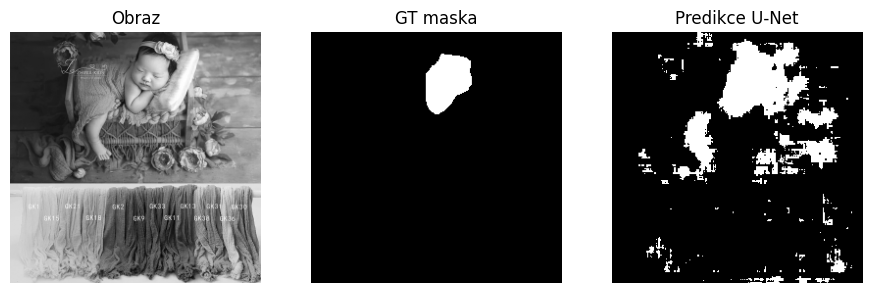

In [12]:
# 9) Vizualizace na jednom validačním vzorku
model.eval()
x,y = val_ds[0]
with torch.no_grad():
    logits = model(x.unsqueeze(0).to(device)).cpu()[0,0].numpy()
    prob   = 1/(1+np.exp(-logits))
pred_bin = (prob > PRED_THR).astype(np.uint8)

fig,axs = plt.subplots(1,3,figsize=(11,4))
axs[0].imshow(x[0], cmap="gray");         axs[0].set_title("Obraz");          axs[0].axis("off")
axs[1].imshow(y[0], cmap="gray");         axs[1].set_title("GT maska");       axs[1].axis("off")
axs[2].imshow(pred_bin, cmap="gray");     axs[2].set_title("Predikce U-Net"); axs[2].axis("off")
plt.show()